## The Curse of Dimensionality

High dimensional space is hard to image, as an example, let's take a look at a tesseract (4d cube aka hypercube):

https://www.youtube.com/watch?v=BVo2igbFSPE

Pretty crazy - and that is only 4 dimensions! What about the thousands of features you just threw at your gradient boosted tree? That is a lot of dimensions! And things behave differently in high dimensions.

For example, "if you pick two points randomly in a unit square, the distance between these two points will be, on average, roughly 0.52. If you pick two random points in a unit 3D cube, the average distance will be roughly 0.66. But what about two points picked randomly in a 1,000,000-dimensional hypercube? Well, the average distance, believe it or not, will be about 408.25." (Source: Hands on Machine Learning p.207)

Thus, in high dimensions, things become very sparse and observations have a higher chance of being far away from eachother. This also applies to our test set or future predictions and thus training points are less likely to generalize to new data points (aka overfitting). 

If you refer back to lecture 4, you will remember to combat overfitting, we can try the following:

* Get more training data
* Try a smaller set of features
* Try a less complex model
* Add regularization

And while in theory all of these work, some can be harder in practice. For example, getting enough data to fill out 1,000 dimensions is not feasible. In this lecture, we will focus on techniques that allow you to use less features without explicitly dropping any individual features. 

## Principle Component Analysis (PCA)

To start off, let's first get a visual understanding:

http://setosa.io/ev/principal-component-analysis/

So - what did we learn? PCA is a technique that projects our data onto the axes with the highest variance. The idea being that it is the least information lost. Thus, the first principal component is the axis that preserves the most variance, the second principal component is the one orthogonal to the first that preserves the next most amount of variance, the third being orthogonal to the first 2 and preserving the next most amount of variance, etc. Note: you can't have more axes then features.

How do we find these principal components? Fortunately, there is a matrix factorization techinque called SVD. Assume you have training data $X$.

SVD says $X = U\Sigma V^{T}$

If you perform this decomposition, $V^{T}$'s columns will be your principal components.

So - let's take a look at an example:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

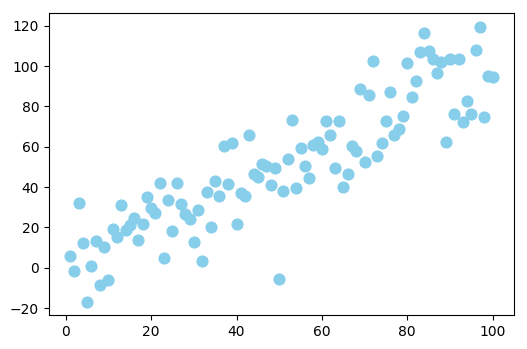

In [7]:
df= pd.DataFrame({'X': range(1,101), 
                  'Y': np.random.randn(100)*15+range(1,101)})
plt.scatter(df['X'], df['Y'], c='skyblue', s=60)

Note: PCA assumes that the data are centered around the origin, so subtract the mean from each column

In [15]:
df_scaled = df - df.mean()
U, s, V = np.linalg.svd(df_scaled.values)
c1 = V.T[:, 0]
c2 = V.T[:, 1]
print(c1)
print(c2)

[0.66195118 0.74954695]
[-0.74954695  0.66195118]


Now that we have these principal components, we just need to project the data onto them. You do this with a simple dot product:

In [16]:
proj_1 = df_scaled.dot(c1)

Here we have projected our data onto the first principal component, let's take a look:

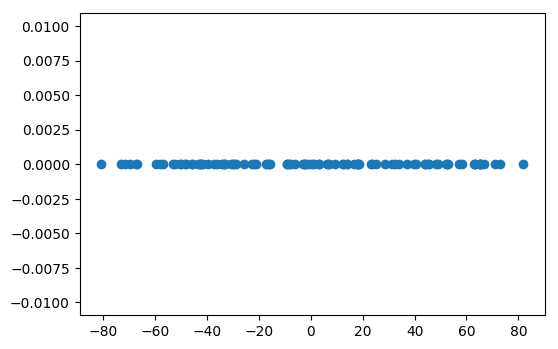

In [22]:
plt.scatter(proj_1, np.zeros(len(proj_1)))

And here is for projecting just on the 2nd component:

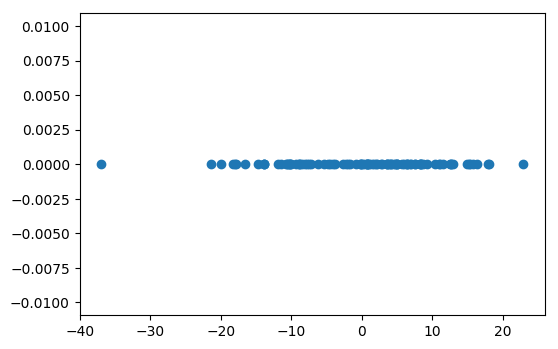

In [23]:
proj_2 = df_scaled.dot(c2)
plt.scatter(proj_2, np.zeros(len(proj_2)))

You can see that the first has more variance than the first. Here is projecting onto the first two together and then inverting the process to show that in fact in reproduces our data. Cool! It exactly reproduces our data because we originally had 2 features and used both principal components.

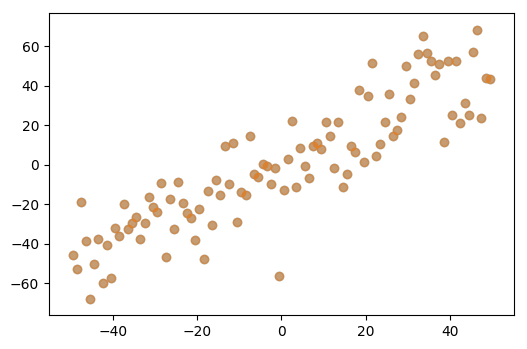

In [38]:
proj_1_2 = df_scaled.dot(V.T)
reconstruct = proj_1_2.dot(V)
plt.scatter(reconstruct.values[:,0], reconstruct.values[:,1], alpha=0.5)
plt.scatter(df_scaled['X'], df_scaled['Y'], alpha=0.5)

We can also check that our principle components are indeed orthogonal. And visually seems to be in high variance directions.

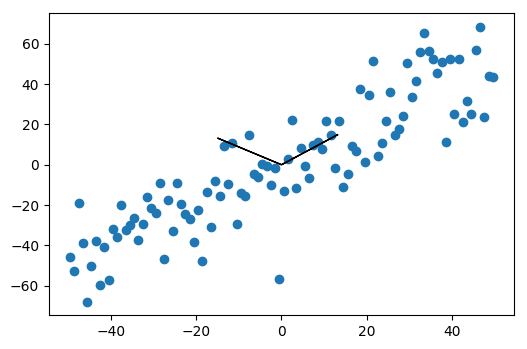

In [48]:
plt.scatter(df_scaled.values[:,0], df_scaled.values[:,1])
plt.arrow(x=0,y=0,dx=c1[0]*20,dy=c1[1]*20)
plt.arrow(x=0,y=0,dx=c2[0]*20,dy=c2[1]*20)

Let's take a look at sklearn (automatically subtracts the mean) and a larger dataset. We create a dataset of 100 features and 1000 samples. Let's first use PCA with 2 components.

In [60]:
from sklearn.datasets import make_regression
from sklearn.decomposition import PCA

In [75]:
X, y = make_regression(n_features=100, n_samples=1000, effective_rank=20)
pca = PCA(n_components=2)
X_2dim = pca.fit_transform(X)

Pretty easy - and how we have a dataset with a much lower dimension:

In [76]:
X_2dim.shape

(1000, 2)

But, how do we choose the number of components to use? A very common method is the **explained variance ratio.** This ratio is the fraction of the dataset's variance that lies along each principal component. They are easy to access in sklearn:

In [77]:
pca.explained_variance_ratio_

array([0.0360053 , 0.03575278])

So - 3.6% of the variance lies along the first principal component and 3.5% along the 2nd, so in using both we explained about 7.1% of the variance - not a lot. Let's graph this ratio cumulatively for all of our components:

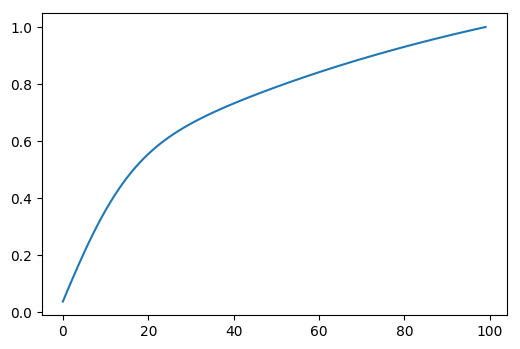

In [78]:
pca = PCA(n_components=100)
X_pca = pca.fit_transform(X)
cum_ratio = np.cumsum(pca.explained_variance_ratio_)
plt.plot(range(len(cum_ratio)), cum_ratio)